# Rethinking Statistics course in pymc3 - Week 9

Lecture 17: Adventures in Covariance

- [Video](https://www.youtube.com/watch?v=yfXpjmWgyXU)
- [Slides](https://speakerdeck.com/rmcelreath/l17-statistical-rethinking-winter-2019)

Lecture 18: Slopes, Instruments and Social Relations

- [Video](https://www.youtube.com/watch?v=e5cgiAGBKzI)
- [Slides](https://speakerdeck.com/rmcelreath/l18-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week09.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week09_solutions.pdf) for the exercises of the week.

In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
from scipy import stats
from scipy.special import expit as logistic
from sklearn import preprocessing

import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
import arviz as az

import warnings
warnings.filterwarnings('ignore')

## Exercise 1

> Revisit the Bangladesh fertility data, data(`bangladesh`). Fit a model with both varying intercepts by `district_id` and varying slopes of `urban` (as a 0/1 indicator variable) by `district_id`. You are still predicting `use.contraception`. Inspect the correlation between the intercepts and slopes. Can you interpret this correlation, in terms of what it tells you about the pattern of contraceptive use in the sample? It might help to plot the varying effect estimates for both the intercepts and slopes, by district. Then you can visualize the correlation and maybe more easily think through what it means to have a particular correlation. Plotting predicted proportion of women using contraception, in each district, with urban women on one axis and rural on the other, might also help.

In [7]:
d = pd.read_csv('../../data/bangladesh.csv', header=0, sep=';')
d['did'] = pd.factorize(d['district'])[0]
d['children'] = preprocessing.scale(d['living.children'])
d['age'] = preprocessing.scale(d['age.centered'])
d.head()

,woman,district,use.contraception,living.children,age.centered,urban,did,children,age
0,1,1,0,4,18.4400,1,0,1.085062,2.046163
1,2,1,0,1,-5.5599,1,0,-1.329794,-0.617262
2,3,1,0,3,1.4400,1,0,0.280110,0.159562
3,4,1,0,4,8.4400,1,0,1.085062,0.936398
4,5,1,0,1,-13.5590,1,0,-1.329794,-1.504975


In [8]:
did = theano.shared(np.array(d['did']))
urban = theano.shared(np.array(d['urban']))
age = theano.shared(np.array(d['age']))
children = theano.shared(np.array(d['children']))
C = theano.shared(np.array(d['use.contraception']))

This is a conventional varying slopes model, with a centered parameterization. No surprises. If you peek at the posterior distributions for the average effects, you'll see that the average slope is positive:

In [9]:
with pm.Model() as model_11:
    # Data is defined outside of the model
    
    # Priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1)
    b_bar = pm.Normal('b_bar', mu=0, sd=0.5)
    sigma = pm.Exponential.dist(lam=1)
    
    # Compute the covariance matrix
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sigma)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    #r = pm.Deterministic('Rho', corr)
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    # we just take the diagonal shifted down one position of the 2x2 matrix, in this case just one value for Rho 
    
    # Logistic regression
    ab_did = pm.MvNormal('ab_did', mu=[a_bar,b_bar], chol=chol, shape=(len(d['did'].unique()), len(d['urban'].unique())))
    p = pm.math.invlogit(ab_did[:, 0][did] + ab_did[:, 1][did]*urban)
    conc_hat = pm.Bernoulli('conc_hat', p=p, observed=C)

    # Prior sampling, trace definition and posterior sampling
    #prior = pm.sample_prior_predictive()
    posterior_11 = pm.sample(tune=2000, target_accept=0.9)
    #posterior_pred_11 = pm.sample_posterior_predictive(posterior_11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_did, chol_cov, b_bar, a_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:46<00:00, 26.71draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [10]:
az.summary(posterior_11, var_names=['a_bar','b_bar', 'sigma_ab','Rho'], credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.69,0.10,0.00,0.00,-0.84,-0.53,1569.0,1569.0,1570.0,1392.0,1.00
b_bar,0.64,0.16,0.00,0.00,0.37,0.88,1225.0,1225.0,1213.0,1319.0,1.00
sigma_ab[0],0.57,0.10,0.00,0.00,0.41,0.72,612.0,612.0,579.0,949.0,1.00
sigma_ab[1],0.77,0.19,0.01,0.01,0.48,1.07,378.0,378.0,379.0,566.0,1.01
Rho[0],-0.65,0.17,0.01,0.01,-0.90,-0.41,408.0,398.0,387.0,743.0,1.01


This implies that urban areas use contraception more. Not surprising. The correlation between the intercepts and slopes is quite negative. Let's plot the individual effects to appreciate this:

In [11]:
aux_plot = pd.DataFrame(np.mean(posterior_11['ab_did'], axis=0)).rename({0:"a",1:"b"}, axis=1)
aux_plot['u0'] = logistic(aux_plot.a)
aux_plot['u1'] = logistic(aux_plot.a+aux_plot.b)

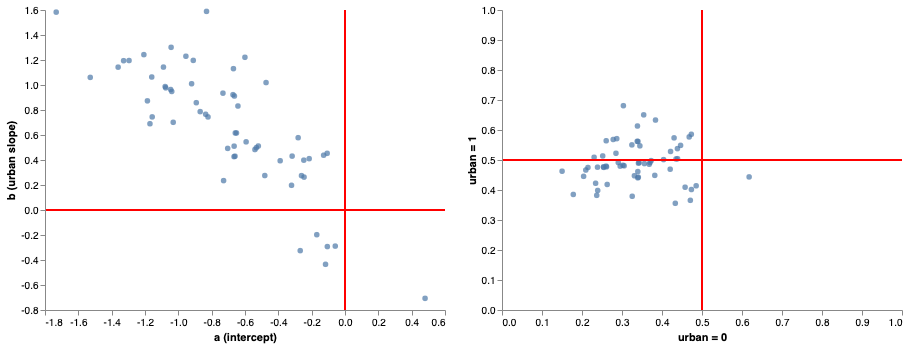

In [28]:
plot = alt.Chart(aux_plot)\
   .mark_circle()\
   .encode(
        x=alt.X('a', title='a (intercept)'),
        y=alt.Y('b', title='b (urban slope)')
          )

scale=alt.Scale(domain=(0,1))
plot2 = alt.Chart(aux_plot)\
   .mark_circle()\
   .encode(
        x=alt.X('u0', title='urban = 0', scale=scale),
        y=alt.Y('u1', title='urban = 1', scale=scale)
          )

rule_v = alt.Chart(aux_plot).mark_rule(color='red').encode(x='v:Q', size=alt.value(1))
rule_h = alt.Chart(aux_plot).mark_rule(color='red').encode(y='v:Q', size=alt.value(1))

alt.hconcat((plot+rule_v+rule_h).transform_calculate(v="0"),
            (plot2+rule_v+rule_h).transform_calculate(v="0.5")).configure_view(stroke=None).configure_axis(grid=False)

There's the negative correlation: districts with higher use outside urban areas (`a` values) have smaller slopes. Since the slope is the difference between urban and non-urban areas, you can see this as saying that districts with high use in rural areas have urban areas that aren't as different.

On the outcome scale, what this ends up meaning is that urban places are much the same in all districts, but rural areas vary a lot. 

_Right_ plot is on the probability scale. The horizontal axis is probability of contraceptive use in rural area of a district. The vertical is the probability in urban area of same district. The urban areas all straddle 0.5. Most the of the rural areas are below 0.5. The negative correlation between the intercepts and slopes is necessary to encode this pattern.

In fact, if we fit the model so it instead has two intercepts, one for rural and one for urban, there is no strong correlation between those intercepts. Here's such a model:

In [33]:
with pm.Model() as model_12:
    # Data is defined outside of the model
    
    # Priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1)
    b_bar = pm.Normal('b_bar', mu=0, sd=1)
    sigma = pm.Exponential.dist(lam=1)
    
    # Compute the covariance matrix
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sigma)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    #r = pm.Deterministic('Rho', corr)
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # Logistic regression
    ab_did = pm.MvNormal('ab_did', mu=[a_bar,b_bar], chol=chol, shape=(len(d['did'].unique()), len(d['urban'].unique())))
    p = pm.math.invlogit(ab_did[did,urban])
    conc_hat = pm.Bernoulli('conc_hat', p=p, observed=C)

    # Prior sampling, trace definition and posterior sampling
    #prior = pm.sample_prior_predictive()
    posterior_12 = pm.sample(tune=2000, target_accept=0.9)
    #posterior_pred_11 = pm.sample_posterior_predictive(posterior_21)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_did, chol_cov, b_bar, a_bar]
Sampling 4 chains, 4 divergences: 100%|██████████| 10000/10000 [01:16<00:00, 131.48draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8338180077353416, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
az.summary(posterior_12, var_names=['a_bar','b_bar', 'sigma_ab','Rho'], credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.71,0.10,0.00,0.00,-0.86,-0.53,1353.0,1319.0,1349.0,1483.0,1.00
b_bar,0.02,0.13,0.00,0.00,-0.17,0.23,666.0,666.0,661.0,1206.0,1.01
sigma_ab[0],0.62,0.11,0.00,0.00,0.46,0.80,541.0,537.0,546.0,1050.0,1.00
sigma_ab[1],0.49,0.17,0.02,0.02,0.22,0.75,68.0,68.0,68.0,105.0,1.04
Rho[0],-0.08,0.28,0.01,0.01,-0.48,0.42,463.0,463.0,463.0,726.0,1.01


Correlation all gone.

## Exercise 2

> Now consider the predictor variables age.centered and living.children, also contained in data(`bangladesh`). Suppose that age influences contraceptive use (changing attitudes) and number of children (older people have had more time to have kids). Number of children may also directly influence contraceptive use. Draw a DAG that reflects these hypothetical relationships. Then build models needed to evaluate the DAG. You will need at least two models. Retain district and urban, as in Problem 1. What do you conclude about the causal influence of age and children?

Here's my DAG:

<img src="../../images/w9_img1.png" width="20%">

`A` is age, `K` is number of children, and `C` is contraception use. To study this DAG, we should estimate both the total causal influence of `A` and then condition also on `K` and see if the direct influence of `A` is smaller. Here's the model for the total influence of A:

In [11]:
with pm.Model() as model_21:
    # Data is defined outside of the model
    
    # Priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1)
    b_bar = pm.Normal('b_bar', mu=0, sd=0.5)
    bA = pm.Normal('bA', mu=0, sd=0.5)
    sigma = pm.Exponential.dist(lam=1)
    
    # Compute the covariance matrix
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sigma)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    #r = pm.Deterministic('Rho', corr)
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # Logistic regression
    ab_did = pm.MvNormal('ab_did', mu=[a_bar,b_bar], chol=chol, shape=(len(d['did'].unique()), len(d['urban'].unique())))
    p = pm.math.invlogit(ab_did[:, 0][did]+ab_did[:, 1][did]*urban + bA*age)
    conc_hat = pm.Bernoulli('conc_hat', p=p, observed=C)

    # Prior sampling, trace definition and posterior sampling
    #prior = pm.sample_prior_predictive()
    posterior_21 = pm.sample(tune=1000)
    #posterior_pred_21 = pm.sample_posterior_predictive(posterior_21)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_did, chol_cov, bA, b_bar, a_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [01:01<00:00, 98.04draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
az.summary(posterior_21, var_names=['a_bar','b_bar', 'bA'], credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.68,0.10,0.0,0.0,-0.85,-0.54,1854.0,1824.0,1863.0,1412.0,1.0
b_bar,0.63,0.16,0.0,0.0,0.39,0.89,955.0,955.0,934.0,1260.0,1.0
bA,0.08,0.05,0.0,0.0,0.00,0.16,2565.0,1935.0,2572.0,1406.0,1.0


In this model, the total causal effect of `age` is positive and very small. Older individuals use slightly more contraception. And now the model with both `K` and `A`:

In [13]:
with pm.Model() as model_22:
    # Data is defined outside of the model
    
    # Priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1)
    b_bar = pm.Normal('b_bar', mu=0, sd=0.5)
    bA = pm.Normal('bA', mu=0, sd=0.5)
    bK = pm.Normal('bK', mu=0, sd=0.5)
    sigma = pm.Exponential.dist(lam=1)
    
    # Compute the covariance matrix
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sigma)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr)
    #r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # Logistic regression
    ab_did = pm.MvNormal('ab_did', mu=[a_bar,b_bar], chol=chol, shape=(len(d['did'].unique()), len(d['urban'].unique())))
    p = pm.math.invlogit(ab_did[:, 0][did]+ab_did[:, 1][did]*urban + bA*age + bK*children)
    conc_hat = pm.Bernoulli('conc_hat', p=p, observed=C)

    # Prior sampling, trace definition and posterior sampling
    #prior = pm.sample_prior_predictive()
    posterior_22 = pm.sample(tune=1000)
    #posterior_pred_22 = pm.sample_posterior_predictive(posterior_22)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_did, chol_cov, bK, bA, b_bar, a_bar]
Sampling 4 chains, 1 divergences: 100%|██████████| 6000/6000 [01:07<00:00, 88.27draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [14]:
az.summary(posterior_22, var_names=['a_bar','b_bar', 'bA', 'bK'], credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.72,0.10,0.0,0.0,-0.89,-0.55,1700.0,1693.0,1706.0,1723.0,1.0
b_bar,0.69,0.16,0.0,0.0,0.44,0.95,1244.0,1239.0,1240.0,1046.0,1.0
bA,-0.26,0.07,0.0,0.0,-0.37,-0.15,1719.0,1719.0,1716.0,1466.0,1.0
bK,0.51,0.07,0.0,0.0,0.40,0.62,1763.0,1763.0,1759.0,1319.0,1.0


In this model, the direct effect of `age` is negative, and much farther from zero than before. The effect of number of children is strong and positive. These results are consistent with the DAG, because they imply that the reason the total effect of age, from `model_21`, is positive is that older individuals also have more kids. Having more kids increases contraception. Being older, controlling for kids, actually makes contraception less likely.

## Exercise 3

> Modify any models from Problem 2 that contained that `children` variable and model the variable now as a monotonic ordered category, like education from the week we did ordered categories. Education in that example had 8 categories. Children here will have fewer (no one in the sample had 8 children). So modify the code appropriately. What do you conclude about the causal influence of each additional child on use of contraception?

In [15]:
d['children'] = d['living.children']-1
children = theano.shared(np.array(d['children'])) # remember for monotonic ordered variables we have to start the categories at zero

To build this model, you need the ordered categorical predictor machinery from the book example. The maximum observed number of kids in the sample is 4. So that means we need three parameters, for three transitions in number of kids.

In [18]:
a = theano.shared(np.zeros(1,))
children_new = d['children'].values
children_new_total = np.zeros((len(children_new), 4), int)
for ic, i in enumerate(children_new):
    if i > 0:
        children_new_total[ic, :i+1] = np.arange(i+1)

In [21]:
children_new_total[30] # i.e. woman with index 30 has two children

array([0, 1, 2, 0])

In [24]:
with pm.Model() as model_31:
    # Data is defined outside of the model
    
    # Priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1)
    b_bar = pm.Normal('b_bar', mu=0, sd=0.5)
    bA = pm.Normal('bA', mu=0, sd=0.5)
    bK = pm.Normal('bK', mu=0, sd=0.5)
    sigma = pm.Exponential.dist(lam=1)
    
    # Compute the covariance matrix
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sigma)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr)
    #r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    children_coefs = pm.Dirichlet('children_coefs', a=np.ones(3))
    children_aux = tt.concatenate([a, children_coefs])
    
    ab_did = pm.MvNormal('ab_did', mu=[a_bar,b_bar], chol=chol, shape=(len(d['did'].unique()), len(d['urban'].unique())))
    p = pm.math.invlogit(ab_did[:, 0][did]+ab_did[:, 1][did]*urban + bA*age + bK*tt.sum(children_aux[children_new_total], axis=1))
    conc_hat = pm.Bernoulli('conc_hat', p=p, observed=C)

    # Prior sampling, trace definition and posterior sampling
    #prior = pm.sample_prior_predictive()
    posterior_31 = pm.sample(tune=2000, target_accept=0.9)
    #posterior_pred_31 = pm.sample_posterior_predictive(posterior_31)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_did, children_coefs, chol_cov, bK, bA, b_bar, a_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [02:29<00:00, 66.89draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [25]:
az.summary(posterior_31, var_names=['a_bar','b_bar', 'bA', 'bK', 'children_coefs'], credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-1.56,0.15,0.01,0.0,-1.78,-1.30,496.0,482.0,492.0,1104.0,1.01
b_bar,0.68,0.16,0.00,0.0,0.44,0.96,1179.0,1179.0,1181.0,1514.0,1.00
bA,-0.21,0.07,0.00,0.0,-0.31,-0.10,1255.0,1255.0,1261.0,1469.0,1.01
bK,1.24,0.15,0.01,0.0,0.98,1.48,469.0,469.0,469.0,1209.0,1.01
children_coefs[0],0.80,0.09,0.00,0.0,0.66,0.94,2932.0,2700.0,2642.0,1306.0,1.00
children_coefs[1],0.13,0.08,0.00,0.0,0.00,0.25,3136.0,2911.0,2601.0,1353.0,1.00
children_coefs[2],0.07,0.05,0.00,0.0,0.00,0.14,3238.0,2281.0,3189.0,1512.0,1.00


So the general effects are the same: `age` reduces use and kids increase it (_parameter `bA`_). `children_coefs[0]` is the transition from 1 to 2 kids. It is much larger than the other two parameters. So most of the influence of kids on contraception comes from having a second child.